# Impact of Signal Correlation on Transaction Cost
## Work in Progress
In this analysis, I want to analyze the impact of signal correlation on portfolio turnover and transaction costs. Considering a set of $N$ distinct signals, I construct $N$ individual strategies. These strategies are based on the assumption that our positions are directly proportional to the corresponding signals. In essence, I treat the signals themselves as our positions.

I then create an equal-weighted portfolio by averaging the positions across all these strategies. The daily adjustments required to maintain this portfolio structure are referred to as trades. Intuitively, one would expect that if the signals are uncorrelated, the trades from different strategies would effectively offset each other. This netting effect should, theoretically, lead to reduced portfolio turnover and lower transaction costs.

However, the sensitivity of turnover and transaction costs to the degree of signal correlation is not immediately obvious. To explore this relationship, a simple simulation study is conducted. This study aims to shed light on how varying levels of correlation between signals might influence the overall cost and efficiency of managing such a portfolio.

In [152]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from functools import partial
from collections import defaultdict
from typing import Callable, Union, List

# Set the style of the axes and the text color
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['axes.labelcolor'] = '#4f4f4f'
plt.rcParams['xtick.color'] = '#4f4f4f'
plt.rcParams['ytick.color'] = '#4f4f4f'
plt.rcParams['text.color'] = '#4f4f4f'

# Set the font
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'

# Set the background color
plt.rcParams['figure.facecolor'] = '#f2f2f2'
plt.rcParams['axes.facecolor'] = '#f2f2f2'

# Set the color palette
sns.set_palette('deep')

In this study, we examine $N$ distinct strategies, each indexed by $i$, with positions $p_{i, t}$ at any given time $t$. These positions follow an Autoregressive Model of the first order (AR(1)) with t-distributed innovations. Notably, these innovations are not isolated but exhibit pairwise correlations across the different strategies. This correlation is integral to our analysis, as it reflects the interconnected nature of the strategies within the broader portfolio framework.

In [160]:
def create_correlated_innovations(rvs: Callable, rho: float) -> Callable:
    assert -1 < rho < 1
    """
    Creates a function to simulate correlated innovations (errors) for multiple signals.

    Parameters:
    rvs (Callable): A function to generate random variables from a specified distribution.
    rho (float): The pairwise correlation coefficient to be applied between signals.

    Returns:
    Callable: A function that generates correlated errors given the number of periods,
              number of signals, and number of simulations.
    """
    def _func(n_periods: int, n_signals: int, n_simulation: int = 1) -> np.ndarray:
        """
        Inner function to generate correlated innovations (errors).

        Parameters:
        n_periods (int): The number of time periods for which to generate errors.
        n_signals (int): The number of distinct signals for which to generate errors.
        n_simulation (int, optional): The number of simulation runs. Default is 1.

        Returns:
        np.ndarray: A NumPy array of correlated errors.
        """
        # Generate independent errors from the specified distribution
        independent_errors = rvs(size=(n_simulation, n_periods, n_signals))

        # Construct a correlation matrix with 'rho' as the off-diagonal elements
        correlation_matrix = np.full((n_signals, n_signals), rho)
        np.fill_diagonal(correlation_matrix, 1)

        # Perform Cholesky decomposition to enable correlation transformation
        try:
            cholesky_decomp = np.linalg.cholesky(correlation_matrix)
        except LinAlgError:
            raise ValueError(f"""A {n_signals} x {n_signals} pairwise 
                correlation {rho} matrix is not positive definite."""
            )
            
        # Apply the Cholesky decomposition to the independent errors
        correlated_errors = independent_errors @ cholesky_decomp
        return correlated_errors

    return _func


The `create_correlated_innovations` function is designed to generate a custom sampling function based on a specified probability distribution and a desired level of pairwise correlation between signals. When you provide it with a probability distribution and a correlation value, it returns a new function. This new function, when called, can produce samples of correlated data in a specified size format: `(n_simulation, n_periods, n_signals)`. Here, `n_simulation` represents the number of simulation runs, `n_periods` is the number of time periods, and `n_signals` indicates the number of different signals. Importantly, these `n_signals` are correlated with each other at the level of correlation you specified, ensuring that the generated data reflects the desired interconnectedness between different signals.

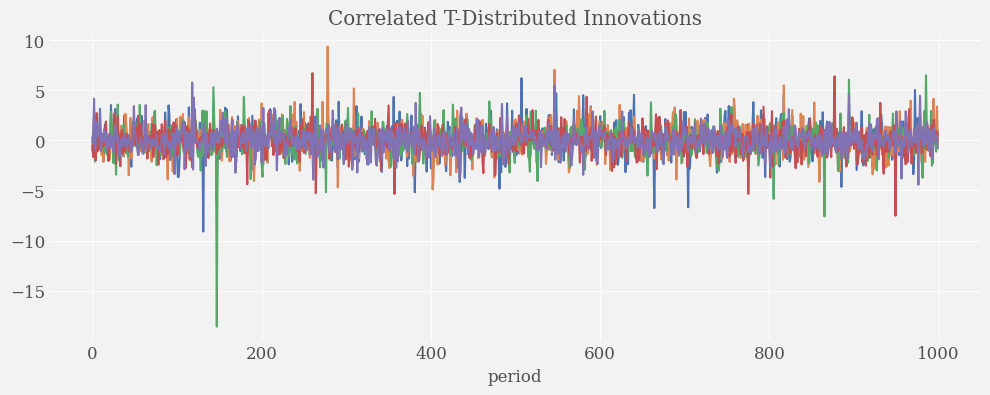

In [180]:
example_innovations = pd.DataFrame(
    np.squeeze(create_correlated_innovations(
        partial(stats.t.rvs, df=5), 0.3
    )(1000, 5))
).rename_axis(
    index='period',
    columns='innovations',
)
example_innovations.plot(figsize=(12, 4), title='Correlated T-Distributed Innovations', legend=None);

In [164]:
import numpy as np
from typing import Callable

def simulate_positions(
    phi: float, 
    innovation_func: Callable, 
    n_periods: int, 
    n_signals: int, 
    n_simulations: int
) -> np.ndarray:
    """
    Simulates positions for an AR(1) process with t-distributed errors.

    Parameters:
    phi (float): The autoregressive coefficient in the AR(1) model.
    innovation_func (Callable): Function to generate the t-distributed errors.
                                It should take the number of periods, signals,
                                and simulations as arguments.
    n_periods (int): Number of time periods for which to simulate the process.
    n_signals (int): Number of distinct signals in the process.
    n_simulations (int): Number of simulation runs.

    Returns:
    np.ndarray: A NumPy array containing the simulated positions for each signal
                and simulation run across the specified time periods.
    """
    # Generate errors using the provided innovation function
    errors = innovation_func(n_periods, n_signals, n_simulations)

    # Initialize an array to store the simulated positions
    H = np.zeros((n_simulations, n_periods, n_signals))

    # Set initial positions equal to the initial errors
    H[:, 0, :] = errors[:, 0, :]

    # Simulate the AR(1) process for each time period, signal, and simulation
    for t in range(1, n_periods):
        H[:, t, :] = phi * H[:, t - 1, :] + errors[:, t, :]

    return H


The `simulate_positions` function is designed to create simulated data for multiple trading signals over a series of time periods. Specifically, it generates position data for a defined number of signals (`n_signals`) across a set number of time periods (`n_periods`). This simulation is repeated for a specified number of iterations (`n_simulations`). The user provides a custom function for generating innovations (random fluctuations), which the simulate_positions function incorporates to model the evolution of each signal’s position over time.

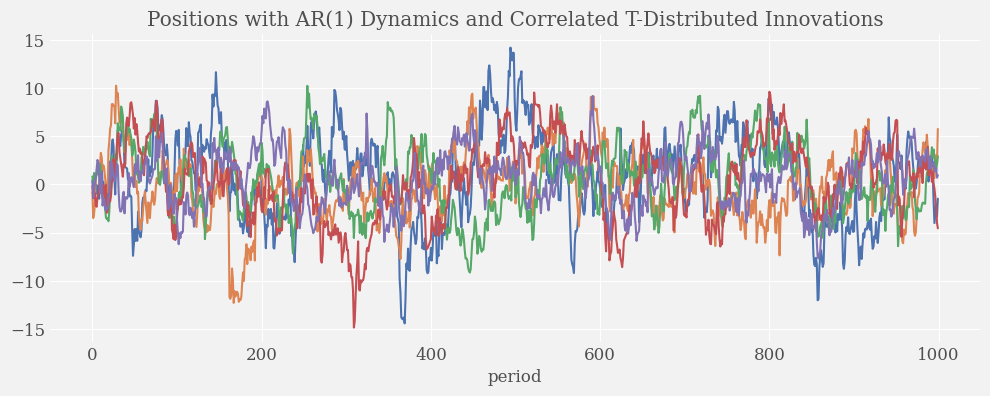

In [179]:
example_positions = pd.DataFrame(
    np.squeeze(simulate_positions(
        0.95,
        create_correlated_innovations(
            partial(stats.t.rvs, df=5), 0.3,
        ), 
        1000, 
        5, 
        1
    ))
).rename_axis(
    index='period',
    columns='innovations',
)
example_positions.plot(figsize=(12, 4), title='Positions with AR(1) Dynamics and Correlated T-Distributed Innovations', legend=None);

In [162]:
def calculate_transaction_costs(trades: Union[np.ndarray, List[float]], k: float) -> Union[np.ndarray, List[float]]:
    """
    Calculates the transaction costs for a given set of trade sizes, 
    using a model where the cost is proportional to the trade size raised to the power of 3/2.

    Parameters:
    trades (Union[np.ndarray, List[float]]): An array or list of trade sizes. 
        Trade sizes can be positive or negative, reflecting buys and sells, respectively.
    k (float): A constant factor representing the proportionality between 
        the transaction cost and the trade size raised to the power of 3/2. 
        This factor is determined by market conditions and the asset being traded.

    Returns:
    Union[np.ndarray, List[float]]: An array or list of transaction costs 
        corresponding to each trade size. The costs are calculated as 
        k * |trade size|^(3/2), reflecting the non-linear relationship between 
        trade size and cost.

    Note:
    - The model assumes that larger trades have a more significant market impact, 
      leading to higher transaction costs. The 3/2 power reflects this disproportionate 
      increase in cost with trade size.
    - The absolute value of the trade size is used because the cost is related to the 
      size of the trade, regardless of whether it is a buy or a sell.
    """
    return k * np.abs(trades)**(3/2)


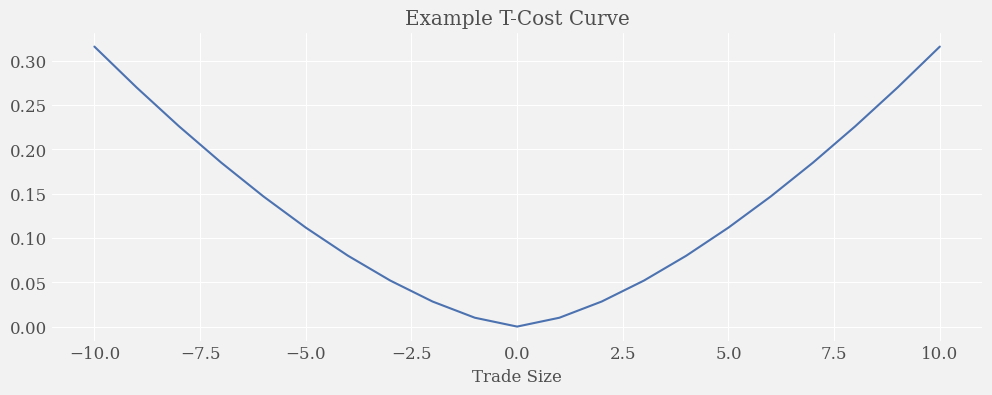

In [181]:
pd.Series(
    calculate_transaction_costs(np.arange(-10, 11), 0.01),
    index=np.arange(-10, 11)
).rename_axis(index='Trade Size').plot(figsize=(12, 4), title='Example T-Cost Curve');

In [202]:
def calculate_turnover(positions: np.ndarray) -> float:
    """
    Calculates the turnover of a portfolio.

    Turnover is defined as the sum of the absolute value of the changes in positions 
    (trades), normalized by the total volume of trades.

    Parameters:
    positions np.ndarray: A 2D array where each columns represents the positions
        in the portfolio at a different time period, and each row is a simulation
        
    Returns:
    float: The calculated turnover of the portfolio.
    """
    # Calculate changes in positions (trades) from one period to the next
    trades = np.diff(positions, axis=1)

    # Calculate the absolute turnover
    turnovers = np.sum(np.abs(trades), axis=1) / np.sum(np.abs(positions[:, :-1]), axis=1)
    turnover = np.mean(turnovers)
    return turnover

We now vary the number of signals and their pairwise correlations, and calculate the transaction costs and turnover of the resulting equal-weighted portfolio.

In [224]:
n_simulations=2000
n_periods=252
k=0.01 # porportionality factor for transaction costs

# Running the simulation for specified numbers of signals and correlaiton
n_signals_list = [1, 2, 5, 10, 20, 30, 40, 50]
corr_list = np.round(np.arange(0, 1, 0.1), 2)
expected_transaction_costs = defaultdict(dict)
expected_turnovers = defaultdict(dict)

for corr in corr_list:
    innovation_func = create_correlated_innovations(
        partial(stats.t.rvs, df=5), corr
    )
    
    # Simulate correlated errors for N signals
    for n_signals in n_signals_list:
        strategy_holdings = simulate_ar1(
            0.95, innovation_func, n_periods, n_signals, n_simulations
        )
        # Average the signals to keep the total risk constant. Sum is not 
        # used because we want to compare the transaction cost of the 
        # portfolio with different number of signals on an almost equal-risk
        # basis. Average is a good enough approximation.
        portfolio_holdings = np.mean(strategy_holdings, axis=2)
        
        # Calculate the trade sizes based on the averaged positions
        trades = np.diff(portfolio_holdings, axis=1)
        
        # Calculate the transaction costs for the trade sizes
        costs = calculate_transaction_costs(trades, k)
        turn_over = calculate_turnover(portfolio_holdings)
        
        # Record the expected transaction cost for this number of signals
        expected_transaction_costs[n_signals][corr] = np.mean(costs)
        expected_turnovers[n_signals][corr] = turn_over

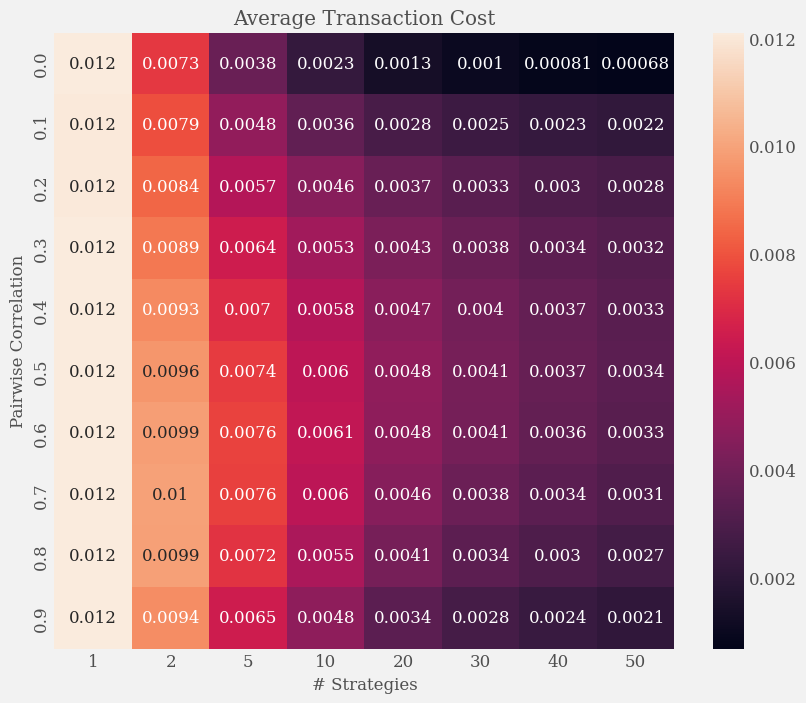

In [225]:
avg_tcosts = pd.DataFrame(expected_transaction_costs).rename_axis(
    index='Pairwise Correlation', columns='# Strategies') 
plt.figure(figsize=(10, 8))
sns.heatmap(avg_tcosts, annot=True)
plt.title('Average Transaction Cost');

For how correlation impacts transaction costs, going across the columns, as the number of strategies increases, more of the trades from different strategies are netted and resulting in less transaction cost. This happens regardless of the average correlation between strategies.

Going down the rows, as average correlations between strategies increase, the transaction cost of the portfolio also increases, but only up to a point. when correlation are as high as 0.8 and 0.9.

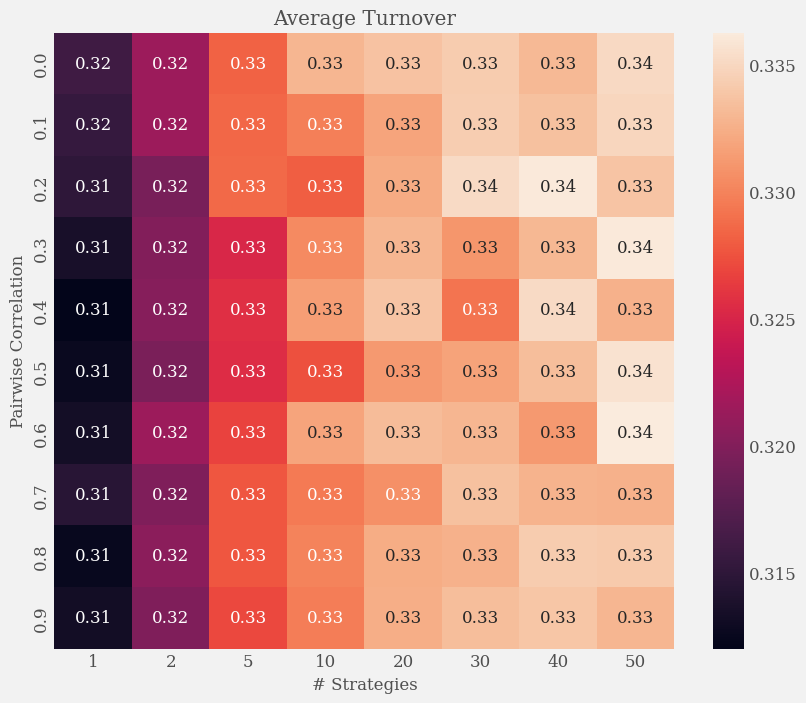

In [226]:
avg_turnover = pd.DataFrame(expected_turnovers).rename_axis(
    index='Pairwise Correlation', columns='# Strategies')
plt.figure(figsize=(10, 8))
sns.heatmap(avg_turnover, annot=True)
plt.title('Average Turnover');